<a href="https://colab.research.google.com/github/missalt/dlo-modeling/blob/main/dlo_modelling_VAE_E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e setup básico

Carregamento das bibliotecas om as ferramentas utitilizadas no projeto.

In [1]:
import os, math, random
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Baixar o dataset

In [25]:
data = np.load('/content/3000_rope_states_actions.npz', allow_pickle=True)
data

NpzFile '/content/3000_rope_states_actions.npz' with keys: states, actions, link_index, link_names, meta

## Fixa semente para reprodutibilidade

In [26]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Carregar dataset .npz e inspecionar chaves/shapes

In [27]:
data = np.load('/content/3000_rope_states_actions.npz', allow_pickle=True)

actions = data['actions']       # (N, 4) = (dx,dy,dz, link_idx)
rope_states = data['states']    # (N, L, 3)
link_names = data.get('link_names', None)

print("states:", rope_states.shape, "actions:", actions.shape)
if link_names is not None:
    print("link_names:", len(link_names))

states: (3000, 70, 3) actions: (3000, 4)
link_names: 70


## Dataset PyTorch com normalização e action-map por elo

In [28]:
class RopeDataset(Dataset):
    """
    Retorna (src_state_t, action_map_t, tgt_state_{t+1}) normalizados.
      - src_state: (L,3)
      - action_map: (L,4) -> (dx,dy,dz, flag) com flag=1.0 no elo acionado
      - tgt_next_state: (L,3)
    """
    def __init__(self, rope_states, actions, normalize=True, mean=None, std=None):
        states = torch.as_tensor(rope_states, dtype=torch.float32)  # (N,L,3)
        actions = torch.as_tensor(actions,     dtype=torch.float32) # (N,4)
        assert states.ndim==3 and states.shape[2]==3
        assert actions.ndim==2 and actions.shape[1]>=4
        assert states.shape[0]==actions.shape[0]
        self.states = states
        self.actions = actions
        self.N, self.L = states.shape[0], states.shape[1]

        if normalize:
            self.mean = self.states.mean(dim=(0,1), keepdim=True)     # (1,1,3)
            self.std  = self.states.std(dim=(0,1), keepdim=True) + 1e-8
        else:
            assert mean is not None and std is not None
            self.mean, self.std = mean, std

        self.states = (self.states - self.mean) / self.std

    def __len__(self):
        return self.N - 1  # prevemos t+1 a partir de t

    def __getitem__(self, idx: int):
        src = self.states[idx]          # (L,3)
        tgt = self.states[idx+1]        # (L,3)
        action = self.actions[idx]      # (4,)
        amap = self._action_to_per_link(action)  # (L,4)
        return src, amap, tgt

    def _action_to_per_link(self, action: torch.Tensor) -> torch.Tensor:
        # (dx,dy,dz, link_idx) -> mapa por elo (L,4)
        amap = torch.zeros(self.L, 4, dtype=torch.float32)
        idx = int(round(float(action[3].item())))
        idx = max(0, min(self.L-1, idx))
        amap[idx, :3] = action[:3]   # vetor de empurrão no elo alvo
        amap[idx, 3]  = 1.0          # flag binária (conserto do bug)
        return amap

## Split consistente (treino/val/test)

In [43]:
def split_data(rope_states, actions, train_ratio=0.8, val_ratio=0.1, seed=42):
    """
    Split the dataset into train, validation, and test sets.
    Ensures rope_states and actions remain aligned.
    """
    np.random.seed(seed)
    n = len(rope_states) - 50
    indices = np.random.permutation(n)
    #indices = range(len(rope_states))
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    n_test = n - n_train - n_val

    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]

    rope_train, rope_val, rope_test = rope_states[train_idx], rope_states[val_idx], rope_states[test_idx]
    actions_train, actions_val, actions_test = actions[train_idx], actions[val_idx], actions[test_idx]

    rope_demo, actions_demo = rope_states[-50:], actions[-50:]
    return (rope_train, rope_val, rope_test), (actions_train, actions_val, actions_test), (rope_demo, actions_demo)

(L,) = (rope_states.shape[1],)  # nº de elos
(rope_train, rope_val, rope_test), (act_train, act_val, act_test), (rope_demo, actions_demo) = split_data(rope_states, actions)

train_ds = RopeDataset(rope_train, act_train, normalize=True)
val_ds   = RopeDataset(rope_val,   act_val,   normalize=False, mean=train_ds.mean, std=train_ds.std)
test_ds  = RopeDataset(rope_test,  act_test,  normalize=False, mean=train_ds.mean, std=train_ds.std)
demo_ds  = RopeDataset(rope_demo,  actions_demo,  normalize=False, mean=train_ds.mean, std=train_ds.std)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False)

train_ds.mean.shape, train_ds.std.shape, L

(torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), 70)

## cVAE: Encoder(q), Reparam, Decoder(p)

In [45]:
class RopeCVAE(nn.Module):
    """
    cVAE para prever s_{t+1} condicionado em s_t e a_t.
      - Encoder vê: concat(s_t, a_t_map, s_{t+1})  -> μ, logσ² de q(z|.)
      - Decoder vê: concat(s_t, a_t_map, z)        -> \hat{s}_{t+1}
    Representamos cada frame como um único vetor: flatten por elo.
    """
    def __init__(self, L: int, d_hidden: int = 512, z_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.L = L
        self.z_dim = z_dim
        # Dimensões de entrada (flatten):
        dim_s   = L*3          # s_t  (L,3) -> 3L
        dim_a   = L*4          # a_t  (L,4) -> 4L
        dim_tgt = L*3          # s_{t+1}
        # Encoder q(z|s,a,tgt)
        enc_in  = dim_s + dim_a + dim_tgt
        self.encoder = nn.Sequential(
            nn.Linear(enc_in, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.mu_head     = nn.Linear(d_hidden, z_dim)
        self.logvar_head = nn.Linear(d_hidden, z_dim)

        # Decoder p(tgt|s,a,z)
        dec_in = dim_s + dim_a + z_dim
        self.decoder = nn.Sequential(
            nn.Linear(dec_in, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, dim_tgt),
        )

    def encode(self, s, a, tgt):
        # s:(B,L,3), a:(B,L,4), tgt:(B,L,3)
        B = s.size(0)
        x = torch.cat([s.reshape(B,-1), a.reshape(B,-1), tgt.reshape(B,-1)], dim=-1)
        h = self.encoder(x)
        mu, logvar = self.mu_head(h), self.logvar_head(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, s, a, z):
        B = s.size(0)
        x = torch.cat([s.reshape(B,-1), a.reshape(B,-1), z], dim=-1)
        out = self.decoder(x)
        return out.view(B, self.L, 3)

    def forward(self, s, a, tgt=None):
        """
        - Se tgt é fornecido: treino (usa encoder para amostrar z).
        - Se tgt é None: inferência (usa z ~ N(0,I)).
        """
        if tgt is not None:
            mu, logvar = self.encode(s, a, tgt)
            z = self.reparameterize(mu, logvar)
            recon = self.decode(s, a, z)
            return recon, mu, logvar
        else:
            B = s.size(0)
            z = torch.randn(B, self.z_dim, device=s.device)
            recon = self.decode(s, a, z)
            return recon

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2678015697.py:5: SyntaxWarning: invalid escape sequence '\h'
  - Decoder vê: concat(s_t, a_t_map, z)        -> \hat{s}_{t+1}


## Função de perda (β-VAE): Recon MSE + β·KL

In [46]:
def vae_loss(recon, tgt, mu, logvar, beta: float = 1e-3):
    # Reconstrução em coords NORMALIZADAS
    recon_loss = nn.functional.mse_loss(recon, tgt, reduction='mean')
    # KL(q||p):  -0.5 * sum(1 + logvar - mu^2 - exp(logvar))   (média por batch)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl, recon_loss, kl

## Treino/Val do cVAE

In [47]:
class RopeCVAE(nn.Module):
    """
    cVAE para prever s_{t+1} condicionado em s_t e a_t.
      - Encoder vê: concat(s_t, a_t_map, s_{t+1})  -> μ, logσ² de q(z|.)
      - Decoder vê: concat(s_t, a_t_map, z)        -> \hat{s}_{t+1}
    Representamos cada frame como um único vetor: flatten por elo.
    """
    def __init__(self, L: int, d_hidden: int = 512, z_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.L = L
        self.z_dim = z_dim
        # Dimensões de entrada (flatten):
        dim_s   = L*3          # s_t  (L,3) -> 3L
        dim_a   = L*4          # a_t  (L,4) -> 4L
        dim_tgt = L*3          # s_{t+1}
        # Encoder q(z|s,a,tgt)
        enc_in  = dim_s + dim_a + dim_tgt
        self.encoder = nn.Sequential(
            nn.Linear(enc_in, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.mu_head     = nn.Linear(d_hidden, z_dim)
        self.logvar_head = nn.Linear(d_hidden, z_dim)

        # Decoder p(tgt|s,a,z)
        dec_in = dim_s + dim_a + z_dim
        self.decoder = nn.Sequential(
            nn.Linear(dec_in, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, dim_tgt),
        )

    def encode(self, s, a, tgt):
        # s:(B,L,3), a:(B,L,4), tgt:(B,L,3)
        B = s.size(0)
        x = torch.cat([s.reshape(B,-1), a.reshape(B,-1), tgt.reshape(B,-1)], dim=-1)
        h = self.encoder(x)
        mu, logvar = self.mu_head(h), self.logvar_head(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, s, a, z):
        B = s.size(0)
        x = torch.cat([s.reshape(B,-1), a.reshape(B,-1), z], dim=-1)
        out = self.decoder(x)
        return out.view(B, self.L, 3)

    def forward(self, s, a, tgt=None):
        """
        - Se tgt é fornecido: treino (usa encoder para amostrar z).
        - Se tgt é None: inferência (usa z ~ N(0,I)).
        """
        if tgt is not None:
            mu, logvar = self.encode(s, a, tgt)
            z = self.reparameterize(mu, logvar)
            recon = self.decode(s, a, z)
            return recon, mu, logvar
        else:
            B = s.size(0)
            z = torch.randn(B, self.z_dim, device=s.device)
            recon = self.decode(s, a, z)
            return recon

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2678015697.py:5: SyntaxWarning: invalid escape sequence '\h'
  - Decoder vê: concat(s_t, a_t_map, z)        -> \hat{s}_{t+1}


## Função de perda (β-VAE): Recon MSE + β·KL

In [48]:
def vae_loss(recon, tgt, mu, logvar, beta: float = 1e-3):
    # Reconstrução em coords NORMALIZADAS
    recon_loss = nn.functional.mse_loss(recon, tgt, reduction='mean')
    # KL(q||p):  -0.5 * sum(1 + logvar - mu^2 - exp(logvar))   (média por batch)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl, recon_loss, kl

## Treino/Val do cVAE

In [49]:
def train_cvae(model, train_loader, val_loader, epochs=100, lr=5e-4, beta=1e-3, ckpt="cvae_best.pt"):
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    best_val = float('inf')

    for ep in range(1, epochs+1):
        model.train()
        tr_total = tr_rec = tr_kl = 0.0
        for s,a,tgt in train_loader:
            s,a,tgt = s.to(device), a.to(device), tgt.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(s,a,tgt)
            loss, rec, kl = vae_loss(recon, tgt, mu, logvar, beta=beta)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            bs = s.size(0)
            tr_total += loss.item()*bs; tr_rec += rec.item()*bs; tr_kl += kl.item()*bs

        # validação
        model.eval()
        val_total = 0.0; count = 0
        with torch.no_grad():
            for s,a,tgt in val_loader:
                s,a,tgt = s.to(device), a.to(device), tgt.to(device)
                recon = model(s, a)
                loss, _, _ = vae_loss(recon, tgt, mu, logvar, beta=beta)
                val_total += loss.item()*s.size(0)
                count += s.size(0)
        val_avg = val_total / max(1,count)
        print(f"Epoch {ep:03d} | TrainLoss={tr_total/len(train_loader.dataset):.4f} "
              f"(rec={tr_rec/len(train_loader.dataset):.4f}, kl={tr_kl/len(train_loader.dataset):.4f}) "
              f"| ValLoss={val_avg:.4f}")
        if val_avg < best_val:
            best_val = val_avg
            torch.save(model.state_dict(), ckpt)
            print(f"Novo melhor modelo salvo: {ckpt} (ValLoss={best_val:.4f})")

    model.load_state_dict(torch.load(ckpt, map_location=device))
    print(f"Carregado melhor checkpoint ({ckpt})")
    return model

## Avaliação no teste (MSE em coords normalizadas)

In [50]:

def evaluate_mse(model, loader):
    model.eval()
    mse_loss = nn.MSELoss(reduction="sum")
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for s, a, tgt in loader:
            s, a, tgt = s.to(device), a.to(device), tgt.to(device)
            # uses posterior q(z | s, a, tgt) -> data leakage
            recon = model(s, a)
            total_loss += mse_loss(recon, tgt).item()
            total_count += tgt.numel()
    return total_loss / total_count

model = RopeCVAE(L=L, d_hidden=512, z_dim=64, dropout=0.2).to(device)
model = train_cvae(model, train_loader, val_loader, epochs=100, lr=5e-4, beta=1e-3, ckpt="cvae_best.pt")
mse_prior = evaluate_mse(model, test_loader)
print(f"Final Test MSE (normalized coords): {mse_prior:.6f}")

Epoch 001 | TrainLoss=0.8369 (rec=0.8359, kl=1.0342) | ValLoss=1.1270
Novo melhor modelo salvo: cvae_best.pt (ValLoss=1.1270)
Epoch 002 | TrainLoss=0.4351 (rec=0.4326, kl=2.4729) | ValLoss=1.1096
Novo melhor modelo salvo: cvae_best.pt (ValLoss=1.1096)
Epoch 003 | TrainLoss=0.4073 (rec=0.4049, kl=2.3884) | ValLoss=1.1069
Novo melhor modelo salvo: cvae_best.pt (ValLoss=1.1069)
Epoch 004 | TrainLoss=0.3680 (rec=0.3656, kl=2.4432) | ValLoss=1.1309
Epoch 005 | TrainLoss=0.3069 (rec=0.3041, kl=2.7357) | ValLoss=1.1254
Epoch 006 | TrainLoss=0.2532 (rec=0.2501, kl=3.0723) | ValLoss=1.1304
Epoch 007 | TrainLoss=0.2146 (rec=0.2115, kl=3.1677) | ValLoss=1.1220
Epoch 008 | TrainLoss=0.1920 (rec=0.1887, kl=3.2821) | ValLoss=1.1023
Novo melhor modelo salvo: cvae_best.pt (ValLoss=1.1023)
Epoch 009 | TrainLoss=0.1506 (rec=0.1471, kl=3.4850) | ValLoss=1.1116
Epoch 010 | TrainLoss=0.1254 (rec=0.1219, kl=3.4634) | ValLoss=1.1182
Epoch 011 | TrainLoss=0.1086 (rec=0.1053, kl=3.3941) | ValLoss=1.1176
Epoch 

## Função deplot 3D (desnormalizando) para uma amostra

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

def plot_rope_pred_cvae(model, dataset, index=0, denormalize=True, train_mean=None, train_std=None):
    model.eval()
    s, a, tgt = dataset[index]
    with torch.no_grad():
        # usa modo "amostrado": gera com z~N(0,I)
        s_b = s.unsqueeze(0).to(device)
        a_b = a.unsqueeze(0).to(device)
        pred = model.forward(s_b, a_b, tgt=None)  # geração condicional

    pred = pred.squeeze(0).cpu()
    s_cpu  = s.cpu()
    tgt_cpu= tgt.cpu()

    if denormalize:
        if train_mean is None or train_std is None:
            raise ValueError("Passe mean/std do treino para desnormalizar.")
        pred = pred * train_std.squeeze(0).squeeze(0) + train_mean.squeeze(0).squeeze(0)
        s_cpu  = s_cpu  * train_std.squeeze(0).squeeze(0) + train_mean.squeeze(0).squeeze(0)
        tgt_cpu= tgt_cpu* train_std.squeeze(0).squeeze(0) + train_mean.squeeze(0).squeeze(0)

    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(s_cpu[:,0],   s_cpu[:,1],   s_cpu[:,2],   'o-', label='State t (real)',  color='green')
    ax.plot(tgt_cpu[:,0], tgt_cpu[:,1], tgt_cpu[:,2], 'o-', label='State t+1 (real)',color='blue')
    ax.plot(pred[:,0],    pred[:,1],    pred[:,2],    'o--',label='State t+1 (VAE)', color='red')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend(); ax.set_title(f"Amostra {index} (cVAE)")
    plt.tight_layout(); plt.show()

## Animação real vs gerado (condicional) para vários frames

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch


def animate_rope(
    model,
    dataset,
    start_idx=0,
    steps=50,
    interval=200,
    device=None,
    denormalize=True,
    save=False,
    train_mean: torch.Tensor = None,
    train_std: torch.Tensor = None,
    dynamic_lim: bool = True
):
    """
    Live animation of predicted vs real rope states over multiple timesteps.

    Args:
        model: Trained model.
        dataset: RopeDataset split (e.g., test set).
        start_idx: Starting frame index.
        steps: Number of steps to animate.
        interval: Delay between frames (ms).
        device: torch.device to use.
        denormalize: Whether to denormalize using training statistics.
        save: If True, saves animation to 'rope_animation.mp4'.
        train_mean: Mean tensor from training set.
        train_std: Std tensor from training set.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    real_line, = ax.plot([], [], [], 'o-', color='blue', label='Real')
    pred_line, = ax.plot([], [], [], 'o--', color='red', label='Predicted')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend(loc="upper left")

    # Optional: dynamic limits using dataset std for scale
    pos = np.array([dataset[i][2] for i in range(steps)])
    if dynamic_lim:
      center = pos.reshape(-1, 3).mean(axis=0)  # [mean_x, mean_y, mean_z]
      std = pos.reshape(-1, 3).std(axis=0)      # [std_x, std_y, std_z]

      # For visualization: use max std across dimensions to get a balanced cube
      lim = std.mean()


      # Apply limits centered around the mean for each axis
      ax.set_xlim([center[0] - lim, center[0] + lim])
      ax.set_ylim([center[1] - lim, center[1] + lim])
      ax.set_zlim([center[2] - lim, center[2] + lim])
    else:
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.5, 1.5])

    def init():
        real_line.set_data([], [])
        real_line.set_3d_properties([])
        pred_line.set_data([], [])
        pred_line.set_3d_properties([])
        return real_line, pred_line

    def update(frame):
        idx = start_idx + frame
        if idx >= len(dataset):
            return real_line, pred_line

        src, action_map, tgt_next = dataset[idx]
        src = src.unsqueeze(0).to(device)
        action_map = action_map.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_next = model(src, action_map)

        pred_next = pred_next.cpu()
        tgt_next = tgt_next.cpu()
        # ✅ Correct de-normalization using *training* stats
        if denormalize:
            tgt_next = tgt_next.unsqueeze(0)
            if train_mean is None or train_std is None:
                raise ValueError("You must provide train_mean and train_std for correct de-normalization.")

            pred_next = pred_next * train_std + train_mean
            tgt_next = tgt_next * train_std + train_mean
            tgt_next = tgt_next.squeeze(0)

        pred_next = pred_next.squeeze(0).cpu()
        real_line.set_data(tgt_next[:, 0], tgt_next[:, 1])
        real_line.set_3d_properties(tgt_next[:, 2])

        pred_line.set_data(pred_next[:, 0], pred_next[:, 1])
        pred_line.set_3d_properties(pred_next[:, 2])

        ax.set_title(f"Frame {idx}")
        return real_line, pred_line

    ani = FuncAnimation(
        fig,
        update,
        frames=min(steps, len(dataset) - start_idx),
        init_func=init,
        blit=False,
        interval=interval,
        repeat=False,
    )

    if save:
        ani.save('rope_animation.mp4', writer='ffmpeg', fps=6)
        print("Saved animation as rope_animation.mp4")
    plt.close(fig)
    return HTML(ani.to_jshtml())


## Rodando algumas visualizações

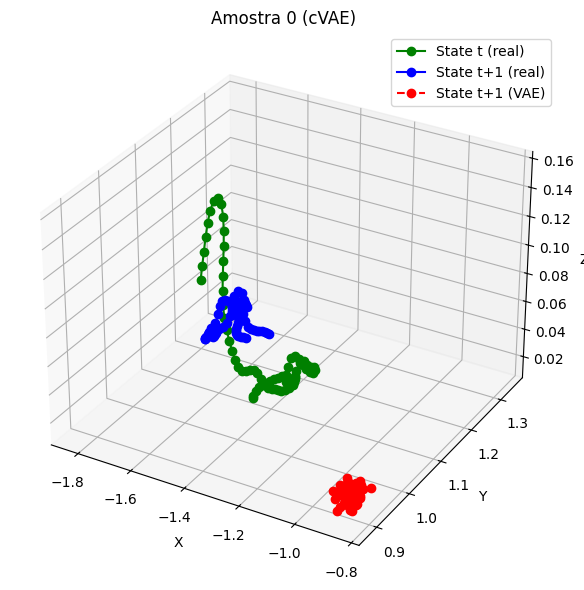

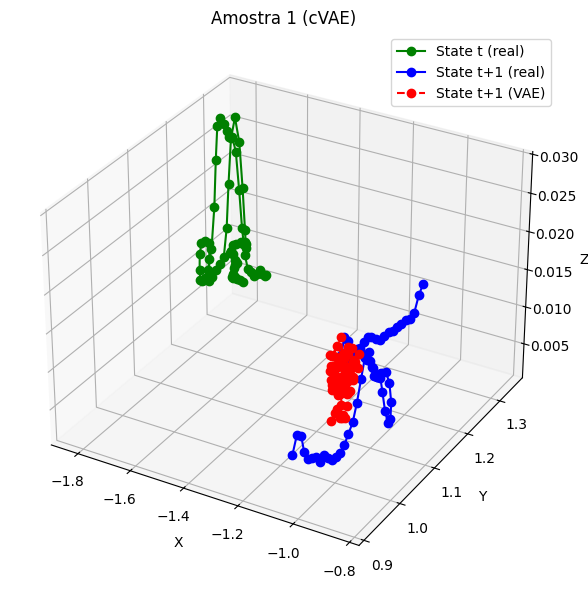

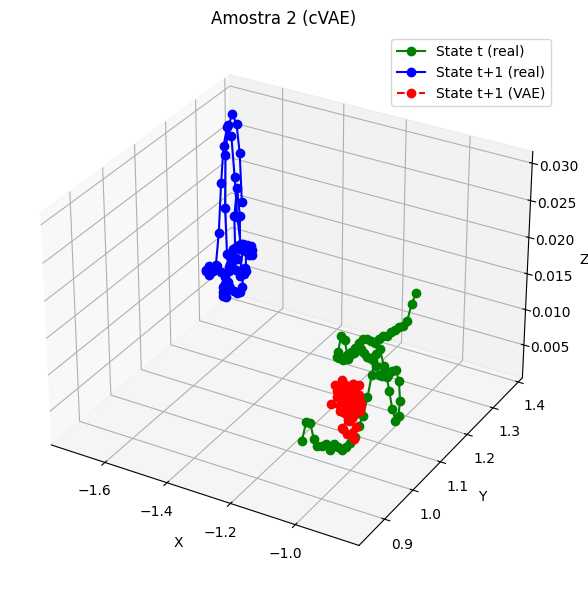

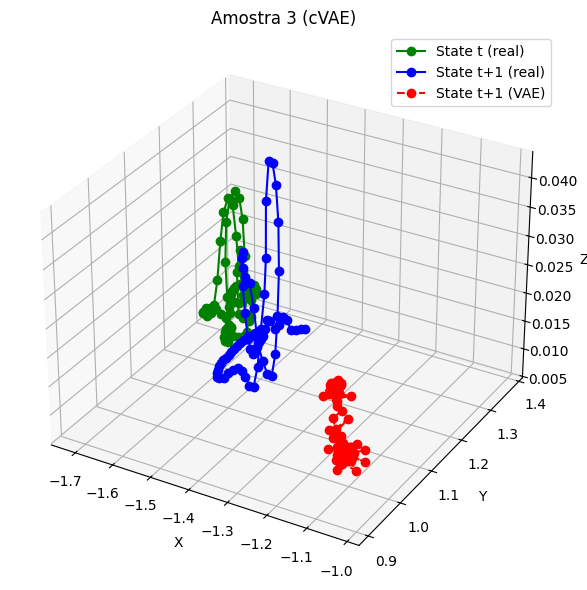

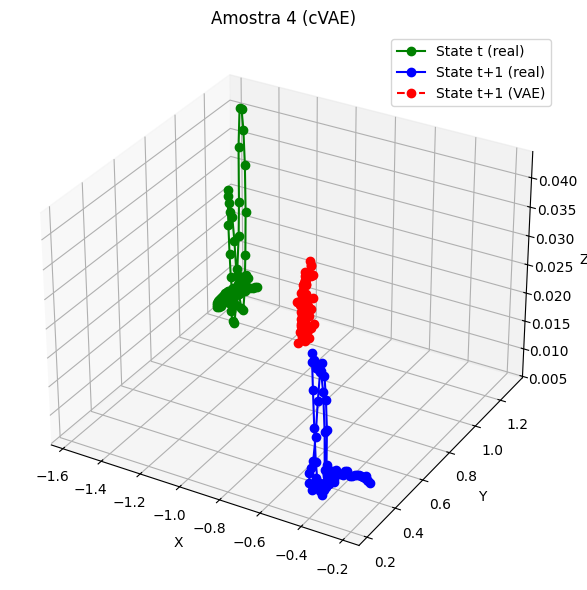

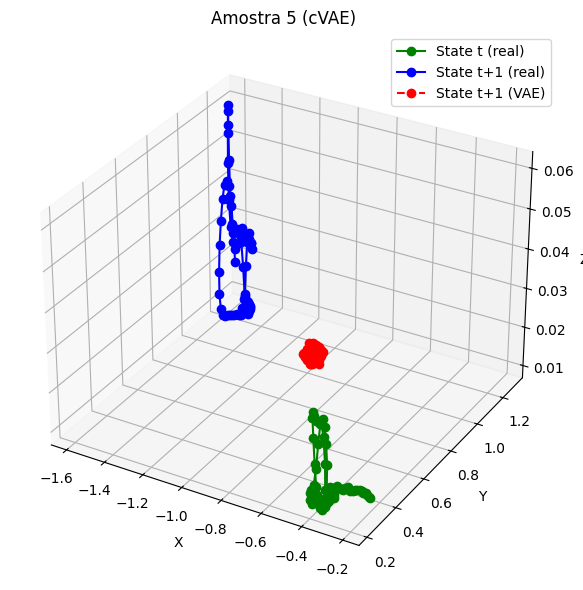

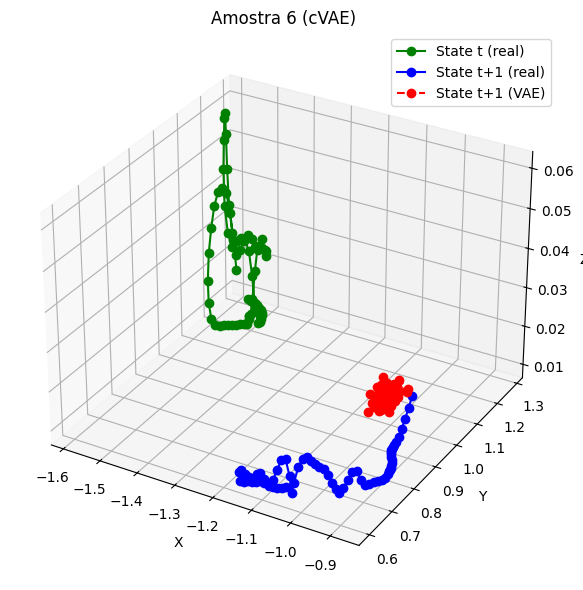

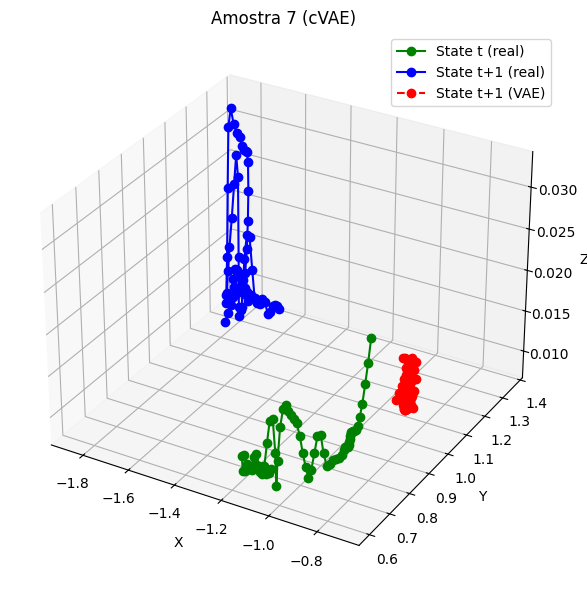

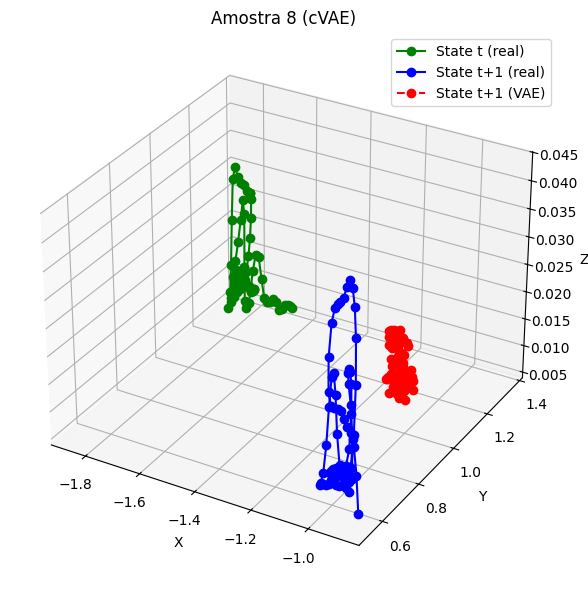

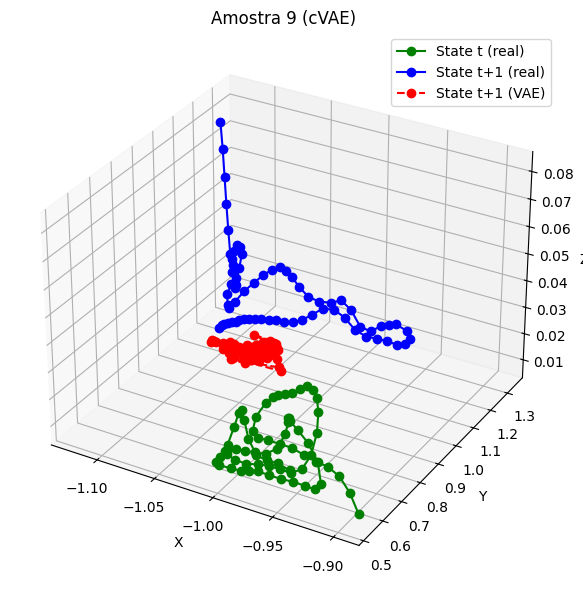

Saved animation as rope_animation.mp4


In [55]:
for i in range(10):
    plot_rope_pred_cvae(model, test_ds, index=i, denormalize=True,
                        train_mean=train_ds.mean, train_std=train_ds.std)

html_anim = animate_rope(model, demo_ds , start_idx=0, steps=48, interval=120, train_mean=train_ds.mean,train_std=test_ds.std, save = True)
html_anim

## Salvar artefatos p/ reuso

In [ ]:
out_dir = "rope_cvae_out"
os.makedirs(out_dir, exist_ok=True)
torch.save({
    "model_state_dict": model.state_dict(),
    "mean": train_ds.mean,
    "std": train_ds.std,
    "L": L
}, os.path.join(out_dir, "cvae_model.pth"))
print("cVAE salvo em", os.path.join(out_dir, "cvae_model.pth"))

cVAE salvo em rope_cvae_out/cvae_model.pth
